# Problem 1: The Eight Schools

Students at eight schools each participated in a test-prep program. After examination, the average score improvement $ \Delta S$ for each school was recorded, along with the uncertainty on this measurement $ \sigma( \Delta S)$:

   + $ \Delta S$ = [28, 8, -3, 7, -1, 1, 18, 12]

   + $ \sigma( \Delta S$) = [15, 10, 16, 11, 9, 11, 10, 18]


a) Calculate the pooled mean improvement and uncertainty on the mean

b) Fit the data using a hierarchical modeling. Assuming the score improvements $\theta = \Delta S$ were drawn from a population that can be modeled as a Gaussian with mean $\mu$ and uncertainty $\sigma$.

* i. Draw your hyperparameters $\alpha = \{\mu, \sigma\}$ from a Gaussian and Half-Cauchy distribution, respectively
* ii. Test other choices of distributions for the hyper-priors and population. How sensitive are the results?

Sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ate_schools = {'school': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 'delta S' : [28, 8, -3, 7, -1, 1, 18, 12], 'sigma' : [15,10, 16, 11, 9, 11, 10, 18]}
df = pd.DataFrame(ate_schools)
df.head()

,school,delta S,sigma
0,A,28,15
1,B,8,10
2,C,-3,16
3,D,7,11
4,E,-1,9


Text(0.5, 0, 'School')

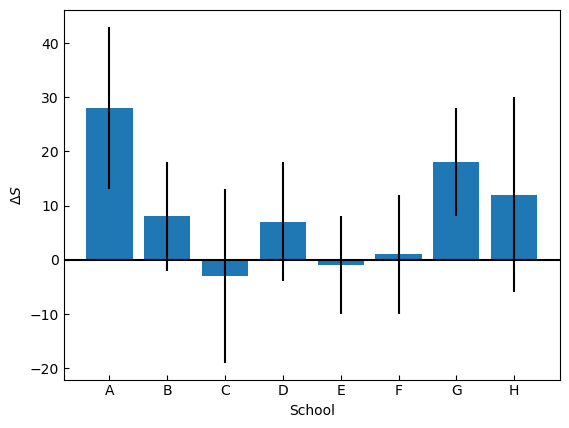

In [26]:
fig, ax = plt.subplots()
ax.bar(df['school'], df['delta S'], yerr = df['sigma'])
ax.tick_params(direction='in')
ax.axhline(0, c='k')
ax.set_ylabel(r'$\Delta S$')
ax.set_xlabel('School')

a)

In [12]:
print(f"Pooled mean: {np.mean(df['delta S'])}")

Pooled mean: 8.75


b)

$$\frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}},$$

In [34]:
np.random.standard_normal()

-0.05077367295249489

In [186]:
from scipy.stats import norm
from scipy.stats import halfcauchy

sample = norm.rvs(loc=10, scale=5)
print(sample)

half_cauchy_sample = halfcauchy.rvs(loc=0, scale=5)
print(half_cauchy_sample)

20.94631472711697
12.163130655404562


In [198]:
def lnprior(a_mu, a_sigma):
    '''
    Calculate the log prior for the school distrinct's distribution

    Parameters
    --------
    a_mu : float
        mean hyperparam
    a_sigma: float
        standard deviation hyperparam
    
    Returns
    --------
    np.log(norm.rvs(a_mu, a_sigma)) : float
        the log-prior for this set of hyperparameters
    '''
    if a_sigma <= 0:
        return -np.inf  # log(0) for impossible parameter values
    draw = norm.rvs(a_mu, a_sigma)
    if draw > 0:
        return np.log(draw)
    else:
        return -np.inf

    

In [229]:
def lnlikelihood(theta, y, y_unc):
    '''
    Calculate the log likelihood for a model assuming Gaussian uncertainties
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnl : float
        The log-likelihood of the observations given the model parameters
    '''
    mu, sigma = theta
    if sigma <= 0:
        return -np.inf 
    model_preds = norm.rvs(loc=theta[0,:], scale=theta[1,:])
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    print(lnl)
    return lnl

In [230]:
def lnprob(theta, y, y_unc):
    '''
    Calculate the product of the likelihood and the prior in ln space hierarchically
    '''
    a_mu = norm.rvs(loc=0, scale=20)
    a_sigma = halfcauchy.rvs(loc=5, scale=5)
    
    lnprobability = lnlikelihood(theta, y, y_unc) + lnprior(a_mu, a_sigma)
    return lnprobability
    

In [231]:
ndim, nwalkers = 8, 100
mu0 = np.random.rand(nwalkers, 8)
sigma0 = np.random.rand(nwalkers, 8)
p0 = np.stack([mu0, sigma0])
import emcee

In [ ]:
np.hstack([np.random.rand(1, 8),  np.random.rand(1, 8)])

array([[0.28249882, 0.30855357, 0.37675607, 0.53310792, 0.48077024,
        0.03804113, 0.82363368, 0.19202686],
       [0.65224665, 0.27716116, 0.36937199, 0.86612217, 0.78783695,
        0.76997245, 0.67491704, 0.46008425]])

In [233]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(df['delta S'], df['sigma']))
sampler.run_mcmc(p0, 1000)

ValueError: incompatible input dimensions (2, 100, 8)

Text(0.5, 0, 'step number')

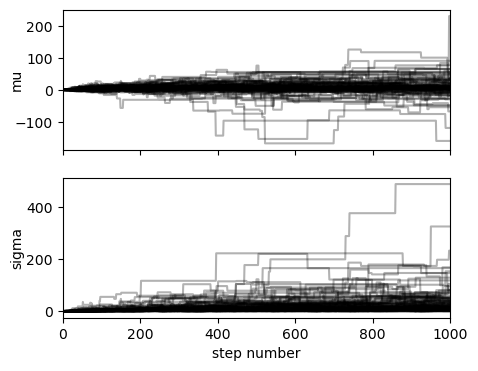

In [203]:
def plot_chains(ax, samples, i, labels):
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

fig, axes = plt.subplots(2, figsize=(5, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]
for i in range(ndim):
    plot_chains(axes[i], samples, i, labels)

axes[-1].set_xlabel("step number")

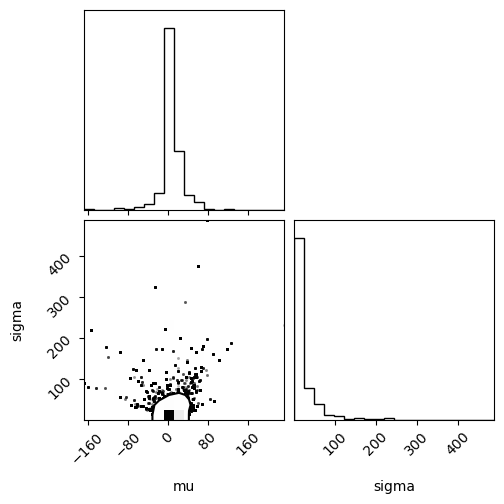

In [204]:
import corner

fig = corner.corner(samples, labels=labels)

# Problem 2: The Five Districts

The test-prep program was expanded across five districts, for a total of 27 schools. For each school, the mean score improvement, uncertainty on the mean, and number of hours each student spent studying was recorded.

### Exercises

a) Load the Five Districts dataset (five_districts.csv) and plot the data
b) Determine the expected score improvement per hour studied for each school using three different models:

+ i. A fully pooled model
+ ii. Independent estimates for each district
+ iii. A hierarchical model that asserts a relationship between the schools and districts.

For all three cases, sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

For the third option, draw the relationship as a directed acyclic graph. Justify your choices of distributions for parameters and hyper-parameters, and test your results for sensitivity to modeling choices.


# Problem 3: Dyson Spheres

Congratulations! You've detected a strange class of objects that you suspect are [Dyson spheres](https://en.wikipedia.org/wiki/Dyson_sphere). Your data are sparse, but you nonetheless detect hints of variability in each object's brightness.

a) Load the Dyson Sphere dataset (dyson_spheres.csv) and plot the time series data. What do you notice about the relative amplitude variations?

b) For each object, compute a Lomb-Scargle periodogram. What do you notice about the frequency-power plot?

c) Assume that each object's time series can be modeled as a single-component sinusoid. Construct a hierarchical model for the population, asserting some population-level relationship between the amplitudes, frequencies, and phases for each object's sinusoid. Which parameters might be expected to be correlated or independent of one another?

# Problem 4: Astrophysics

Select an astrophysical dataset of your choosing. Describe any hierarchical structure in the data using a directed acyclic graph. Build a simple hierarchical model for the data. You may wish to use only a few member objects of your dataset in order to more rapidly iterate while developing.